In [1]:
from time import sleep
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
import matplotlib.ticker as ticker
import pandas as pd
import numpy as np
from numpy import atleast_2d
from random import shuffle
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from sklearn.neighbors import KDTree

In [2]:
%matplotlib notebook
cmap = cm.get_cmap('viridis')
pd.options.display.float_format = '{:,.2f}'.format

### Load Iris Data

In [3]:
# 数据准备，使用Iris数据集
iris = load_iris()
iris.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename'])

### Create DataFrame

In [4]:
# 处理数据集，共需5列，前四列为特征，最后一列为label，为显示方便将特征标准化后降维至2维
features = iris.feature_names
data = pd.DataFrame(data=np.column_stack([iris.data, iris.target]), 
                    columns=features + ['label'])
data.label = data.label.astype(int)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   label              150 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 6.0 KB


In [5]:
len(set(data['label']))

3

In [6]:
data[features]

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.10,3.50,1.40,0.20
1,4.90,3.00,1.40,0.20
2,4.70,3.20,1.30,0.20
3,4.60,3.10,1.50,0.20
4,5.00,3.60,1.40,0.20
...,...,...,...,...
145,6.70,3.00,5.20,2.30
146,6.30,2.50,5.00,1.90
147,6.50,3.00,5.20,2.00
148,6.20,3.40,5.40,2.30


### Standardize Data

In [7]:
# StandardScaler类是一个用来讲数据进行归一化和标准化的类。-计算训练集的平均值和标准差，以便测试数据集使用相同的变换。
scaler = StandardScaler()
features_standardized = scaler.fit_transform(data[features])
n = len(data)

### Reduce Dimensionality to visualize clusters

In [8]:
pca = PCA(n_components=2)
features_2D = pca.fit_transform(features_standardized)

<IPython.core.display.Javascript object>


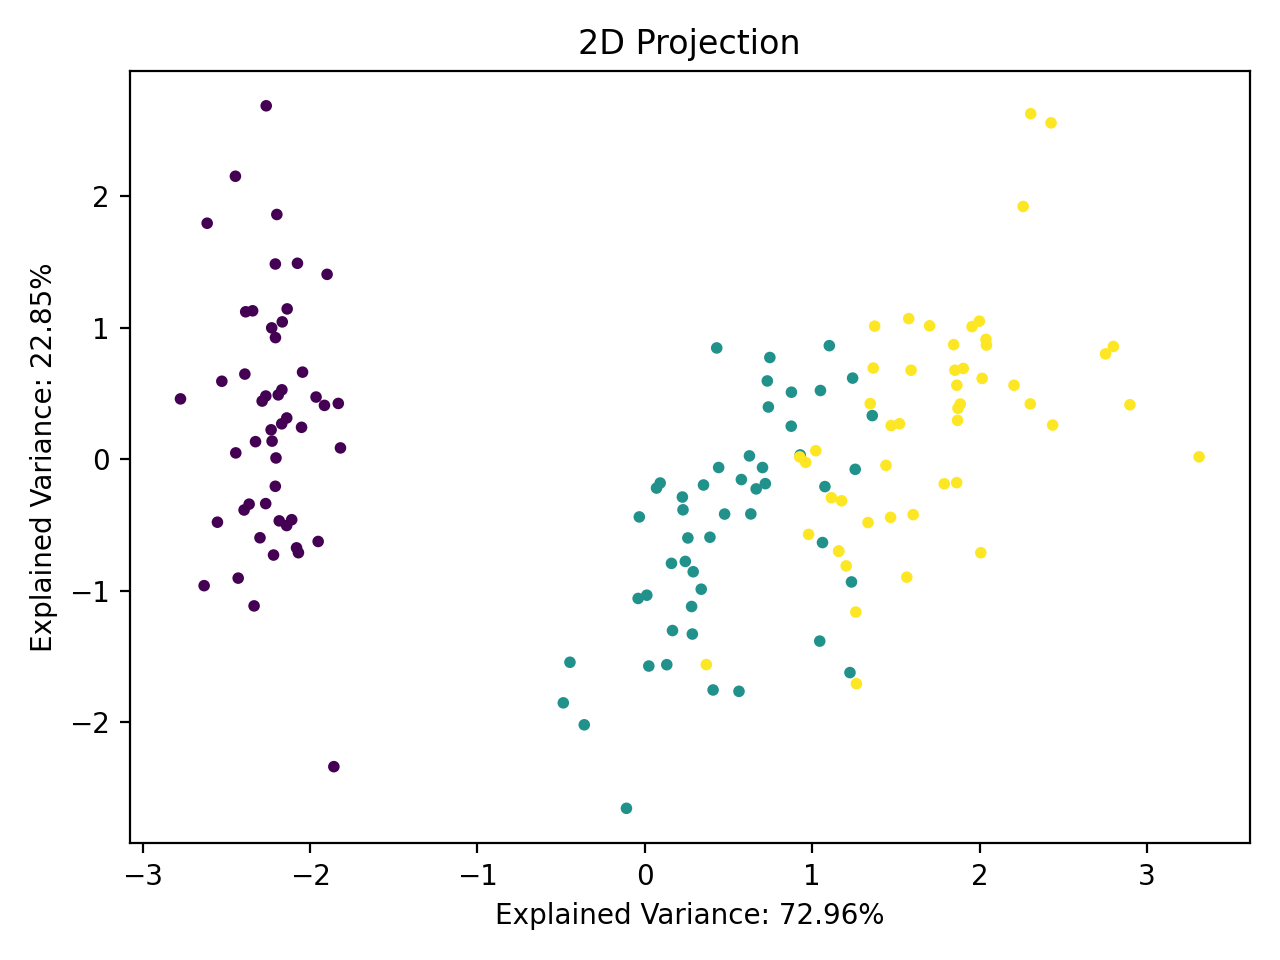

In [9]:
ev1, ev2 = pca.explained_variance_ratio_
ax = plt.figure().gca(title='2D Projection', 
                      xlabel='Explained Variance: {:.2%}'.format(ev1), 
                      ylabel='Explained Variance: {:.2%}'.format(ev2))
ax.scatter(*features_2D.T, c=data.label, s=10)
plt.tight_layout();

### Perform DBSCAN clustering

<IPython.core.display.Javascript object>


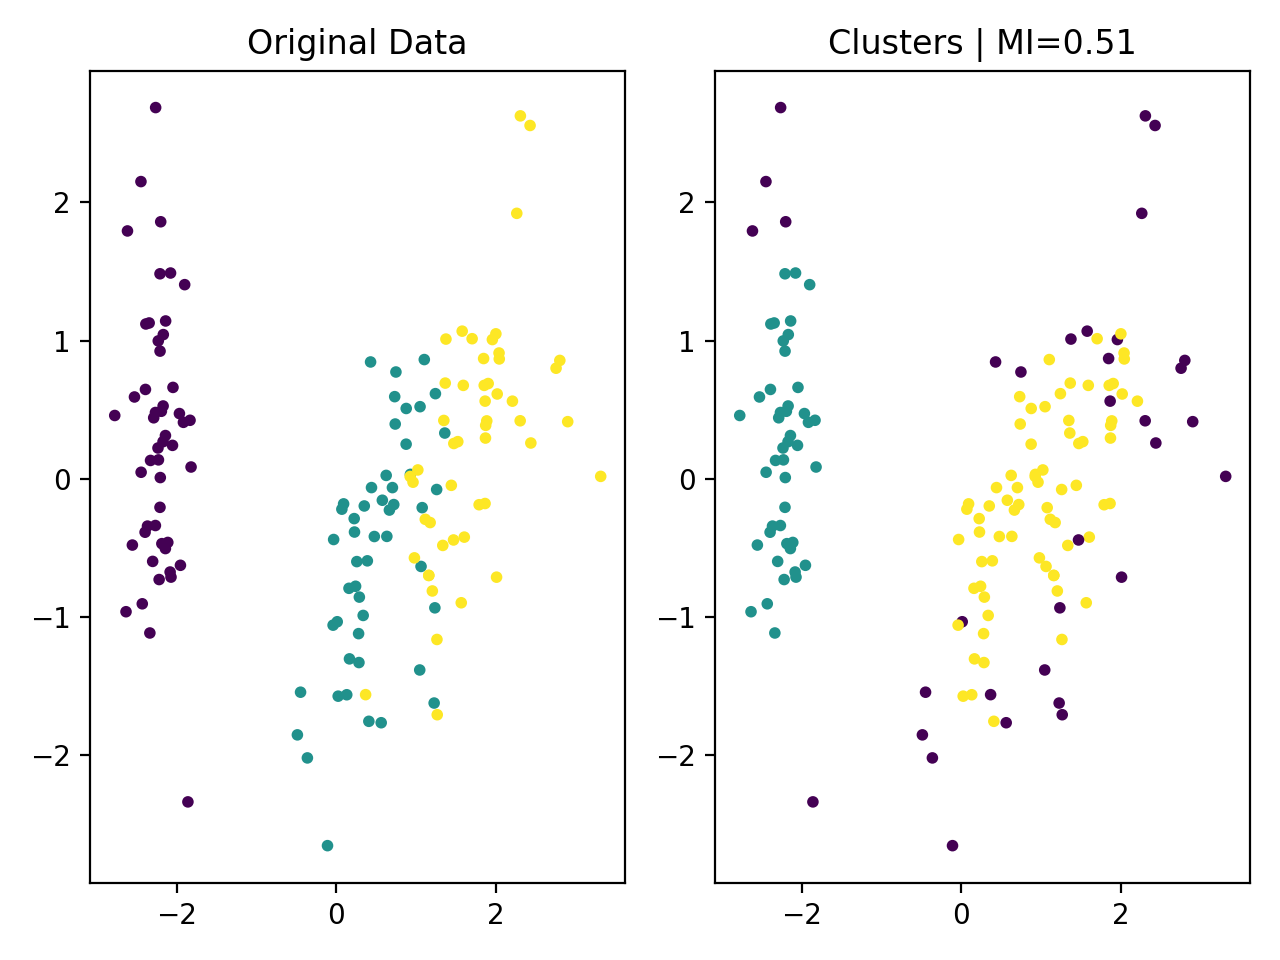

In [10]:
# 初始化一个DBSCAN，未调整参数，MI值表现较差
clusterer = DBSCAN()
data['clusters'] = clusterer.fit_predict(features_standardized)
fig, axes = plt.subplots(ncols=2)
labels, clusters = data.label, data.clusters
mi = adjusted_mutual_info_score(labels, clusters)
axes[0].scatter(*features_2D.T, c=data.label, s=10)
axes[0].set_title('Original Data')
axes[1].scatter(*features_2D.T, c=data.clusters, s=10)
axes[1].set_title('Clusters | MI={:.2f}'.format(mi))
plt.tight_layout()

### Compare parameter settings

In [11]:
# 根据热力图选择合适参数
eps_range = np.arange(.2, .91, .05)
min_samples_range = list(range(3, 10))
labels = data.label
mi = {}
for eps in eps_range:
    for min_samples in min_samples_range:
        clusterer = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = clusterer.fit_predict(features_standardized)  
        mi[(eps, min_samples)] = adjusted_mutual_info_score(clusters, labels)

<IPython.core.display.Javascript object>


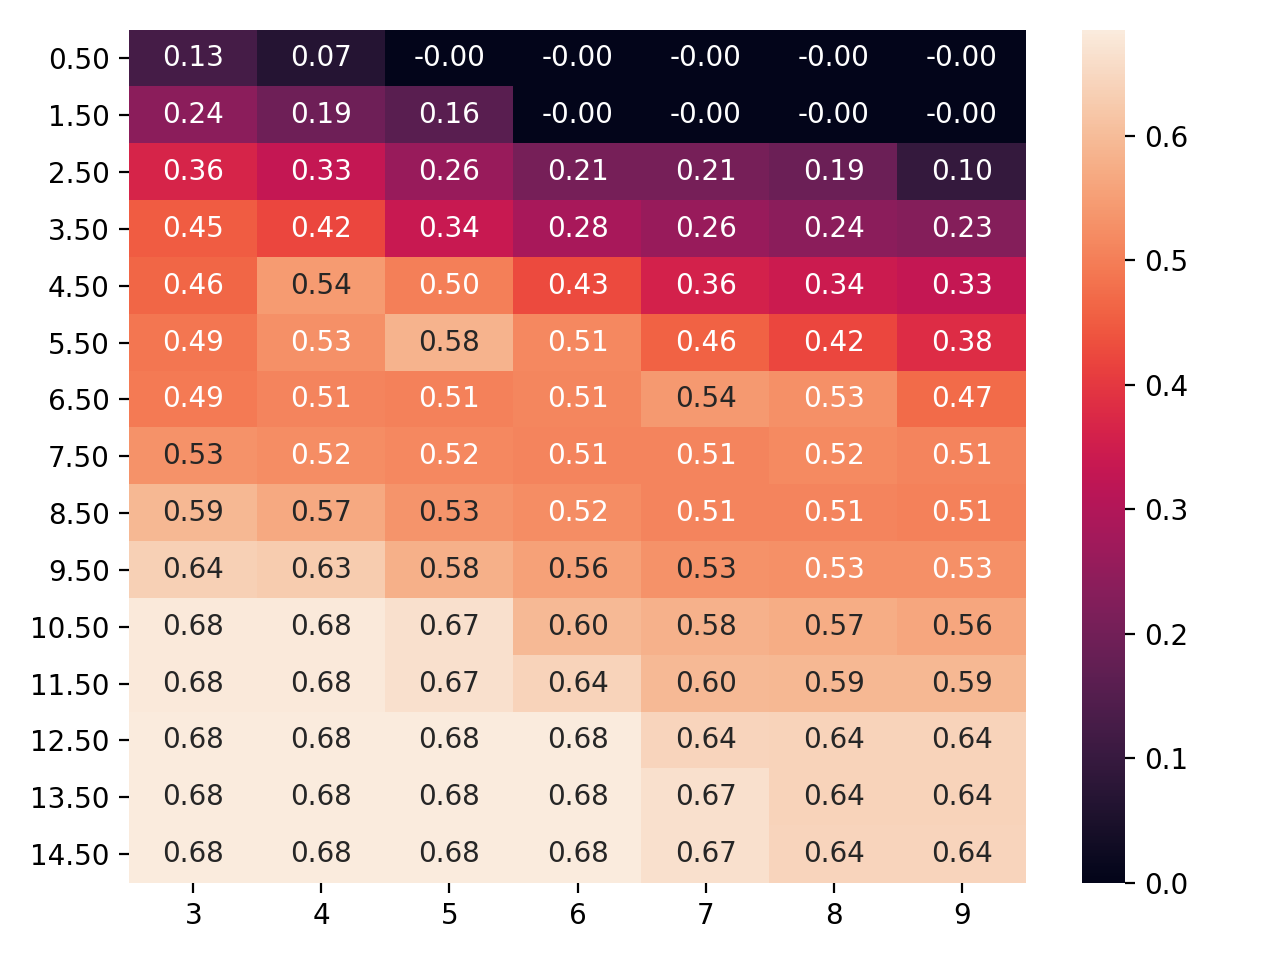

In [12]:
results = pd.Series(mi)
results.index = pd.MultiIndex.from_tuples(results.index)
fig, axes = plt.subplots()
ax = sns.heatmap(results.unstack(), annot=True, fmt='.2f')
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
plt.tight_layout()

In [13]:
results.unstack()

,3,4,5,6,7,8,9
0.20,0.13,0.07,-0.00,-0.00,-0.00,-0.00,-0.00
0.25,0.24,0.19,0.16,-0.00,-0.00,-0.00,-0.00
0.30,0.36,0.33,0.26,0.21,0.21,0.19,0.10
0.35,0.45,0.42,0.34,0.28,0.26,0.24,0.23
0.40,0.46,0.54,0.50,0.43,0.36,0.34,0.33
0.45,0.49,0.53,0.58,0.51,0.46,0.42,0.38
0.50,0.49,0.51,0.51,0.51,0.54,0.53,0.47
0.55,0.53,0.52,0.52,0.51,0.51,0.52,0.51
0.60,0.59,0.57,0.53,0.52,0.51,0.51,0.51
0.65,0.64,0.63,0.58,0.56,0.53,0.53,0.53


### Run again

<IPython.core.display.Javascript object>


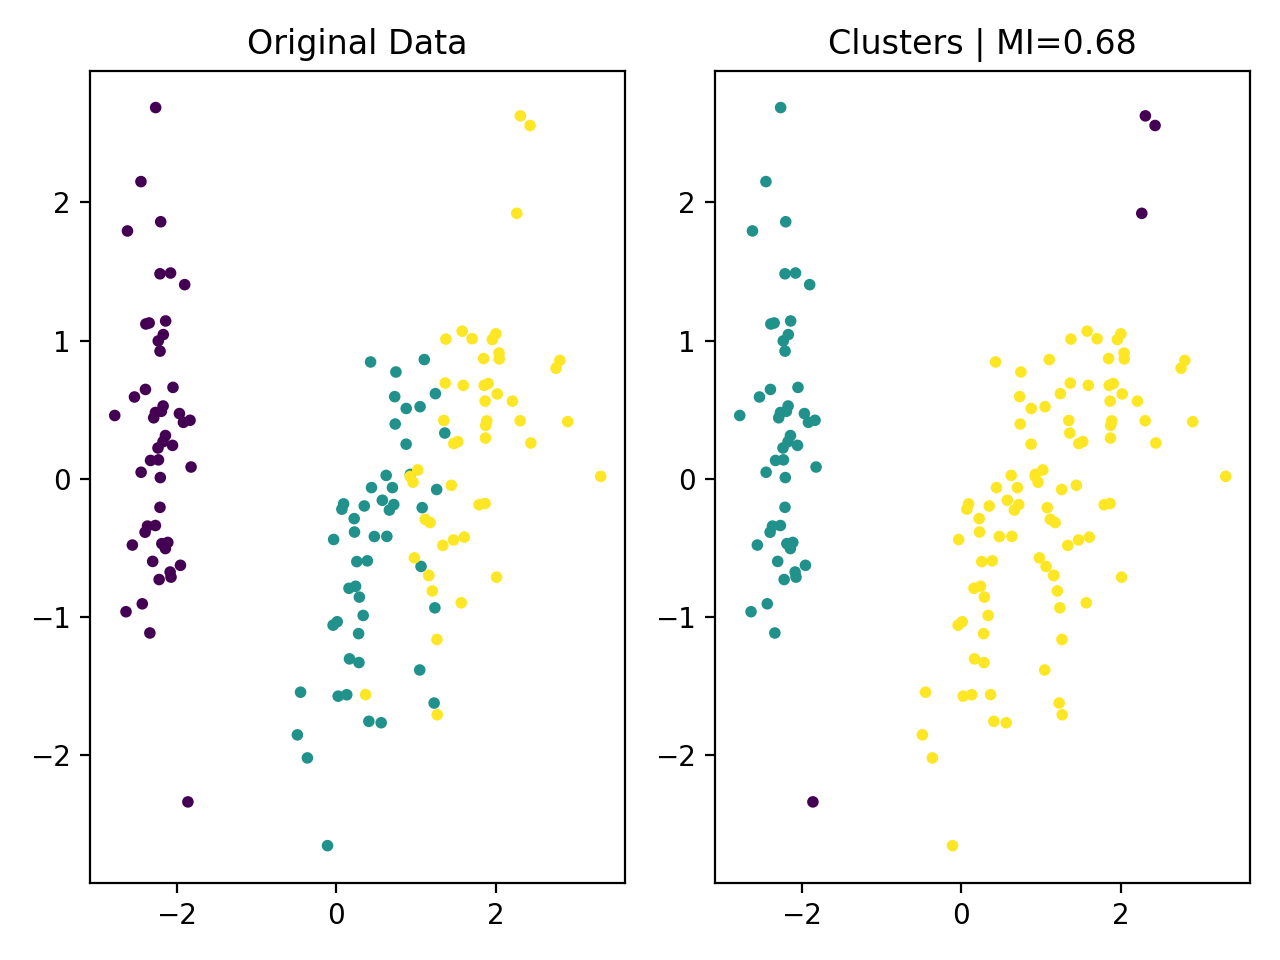

In [14]:
clusterer = DBSCAN(eps=.8, min_samples=5)
data['clusters'] = clusterer.fit_predict(features_standardized)
fig, axes = plt.subplots(ncols=2)
labels, clusters = data.label, data.clusters
mi = adjusted_mutual_info_score(labels, clusters)
axes[0].scatter(*features_2D.T, c=data.label, s=10)
axes[0].set_title('Original Data')
axes[1].scatter(*features_2D.T, c=data.clusters, s=10)
axes[1].set_title('Clusters | MI={:.2f}'.format(mi))
plt.tight_layout()